In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
path = untar_data(URLs.CAMVID)

In [5]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images')]

In [3]:
path_label = path/'labels'
path_img = path/'images'

In [4]:
fnames = get_image_files(path_img)

In [8]:
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_007470.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_008700.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_010320.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f02310.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_008310.png')]

In [5]:
label_names = get_image_files(path_label)

In [10]:
label_names[:5]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_007170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_06600_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f04050_P.png')]

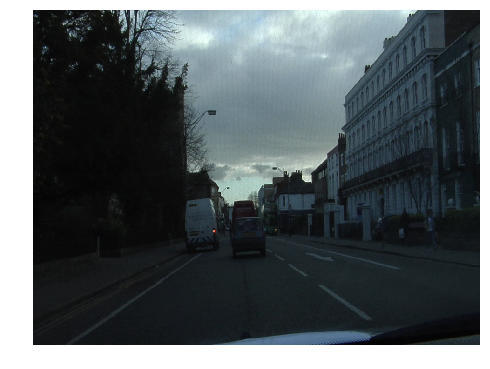

In [13]:
img = open_image(fnames[0])
img.show(figsize = (8,8))

The following function searches for the equivalent masked files in the labels directory

In [6]:
get_y_fn = lambda x: path_label/f'{x.stem}_P{x.suffix}'

In [8]:
mask = open_mask(fnames[0])

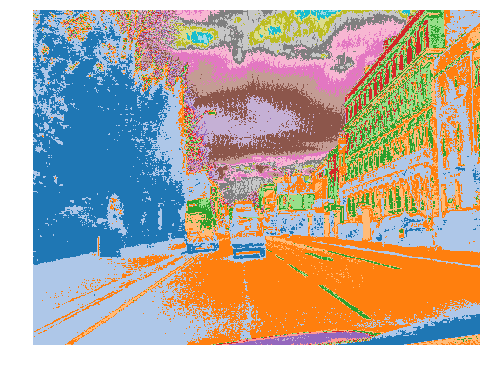

In [17]:
mask.show(figsize = (8,8), alpha = 1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 42,  35,  30,  ...,  22,  22,  24],
          [ 35,  26,  22,  ...,  22,  22,  24],
          [ 24,  19,  15,  ...,  23,  23,  24],
          ...,
          [ 21,  19,  18,  ...,  41,  39,  36],
          [ 18,  18,  18,  ...,  39,  37,  32],
          [ 16,  16,  17,  ...,  36,  34,  33]]]))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype = str)
print(codes)

['Animal' 'Archway' 'Bicyclist' 'Bridge' 'Building' 'Car' 'CartLuggagePram' 'Child' 'Column_Pole' 'Fence'
 'LaneMkgsDriv' 'LaneMkgsNonDriv' 'Misc_Text' 'MotorcycleScooter' 'OtherMoving' 'ParkingBlock' 'Pedestrian' 'Road'
 'RoadShoulder' 'Sidewalk' 'SignSymbol' 'Sky' 'SUVPickupTruck' 'TrafficCone' 'TrafficLight' 'Train' 'Tree' 'Truck_Bus'
 'Tunnel' 'VegetationMisc' 'Void' 'Wall']


# Creating a databunch

In [17]:
size = src_size//2
bs = 8
print(size)

[360 480]


In [12]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes = codes))

In [13]:
data = (src.transform(get_transforms(), size = size, tfm_y = True)
       .databunch(bs = bs)
       .normalize(imagenet_stats))

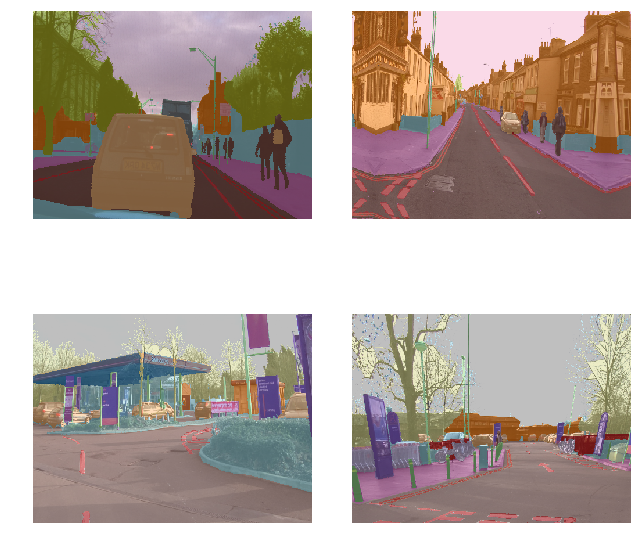

In [14]:
data.show_batch(2, figsize = (9,9))

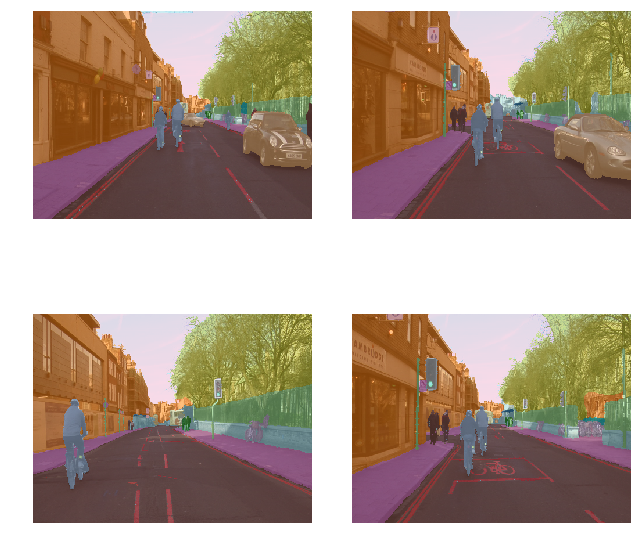

In [26]:
data.show_batch(2, figsize = (9,9), ds_type = DatasetType.Valid)

# Model

In [15]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def camvid_acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim = 1)[mask] == target[mask]).float().mean()

In [16]:
learn = Learner.create_unet(data, models.resnet34, metrics = [camvid_acc])

RuntimeError: CUDA error: out of memory